In [21]:
import os
import numpy as np
import argparse
import itertools
import torch
from torchvision.transforms import InterpolationMode
import pickle

from collections import defaultdict

from utils import read_results, write_results

In [31]:
# read cw results
cw_results = read_results("attack_results/mnist_cw_1.1_results")
len(cw_results)
# write_results("attack_results/mnist_cw_1.1_results", {}, overwrite=True)

0

In [32]:
from load_ens_adv_train import get_ens_adv_model

model = get_ens_adv_model()
torch.save(model.state_dict(), "trained_models/resnet18_ens_adv.pth")

In [2]:
# load fgsm experiment results
fgsm_results = {}
folder = 'attack_results/'
for fp in os.listdir(folder):
    if 'fgsm' in fp:
        print(fp)
        results = read_results(folder + fp)
        # update total results
        fgsm_results.update(results)

print(len(fgsm_results))

cifar10_fgsm_1.1_results
mnist_fgsm_1.1_results
cifar10_fgsm_2.0_results
mnist_fgsm_2.0_results
2882


In [3]:
print(list(fgsm_results.values())[0])

('fgsm', 'cifar10', 1.1, 0, 3, 'bilinear', 0.01953125, 10, 0.01, False, 0.1, 'simple_avg', 0.35019999742507935, inf)


In [17]:
# convert to pandas dataframe
import pandas as pd
df = pd.DataFrame.from_dict(fgsm_results, orient='index').reset_index(drop=True)
df.columns = """attack_type, dataset, scaling_factor, up_samplers, down_samplers, interpolation, epsilon, nb_iter, eps_iter, rand_init, initial_const, linear_voting, test_acc, norm""".split(", ")
df['num_models'] = df['up_samplers'] + df['down_samplers'] + 1
df

,attack_type,dataset,scaling_factor,up_samplers,down_samplers,interpolation,epsilon,nb_iter,eps_iter,rand_init,initial_const,linear_voting,test_acc,norm,num_models
0,fgsm,cifar10,1.1,0,3,bilinear,0.019531,10.0,0.01,False,0.1,simple_avg,0.3502,inf,4
1,fgsm,cifar10,1.1,0,3,bilinear,0.019531,10.0,0.01,False,0.1,majority_vote,0.3589,inf,4
2,fgsm,cifar10,1.1,0,3,bilinear,0.039062,10.0,0.01,False,0.1,simple_avg,0.1856,inf,4
3,fgsm,cifar10,1.1,0,3,bilinear,0.039062,10.0,0.01,False,0.1,majority_vote,0.1938,inf,4
4,fgsm,cifar10,1.1,0,3,bilinear,0.0625,10.0,0.01,False,0.1,simple_avg,0.1347,inf,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2877,fgsm,mnist,2.0,2,0,bilinear,0.039062,10.0,0.01,False,0.1,majority_vote,0.9840,inf,3
2878,fgsm,mnist,2.0,2,0,bilinear,0.0625,10.0,0.01,False,0.1,majority_vote,0.9720,inf,3
2879,fgsm,mnist,2.0,2,0,bilinear,0.019531,10.0,0.01,False,0.1,weighted_vote,0.9880,inf,3
2880,fgsm,mnist,2.0,2,0,bilinear,0.039062,10.0,0.01,False,0.1,weighted_vote,0.9840,inf,3


In [12]:
# filter epsilon 0.0625	and dataset cifar10
df = df[(df['epsilon'] == 0.0625) & (df['dataset'] == 'cifar10')]

# max, mean, min test accuracy
np.min(df['test_acc']), np.mean(df['test_acc']), np.max(df['test_acc'])

(0.1242000013589859, 0.14974097265965408, 0.26030001044273376)

In [13]:
# show max entry
df[df['test_acc'] == np.max(df['test_acc'])]

,attack_type,dataset,scaling_factor,up_samplers,down_samplers,interpolation,epsilon,nb_iter,eps_iter,rand_init,initial_const,linear_voting,test_acc,norm,num_models
1642,fgsm,cifar10,2.0,3,3,bilinear,0.0625,10.0,0.01,False,0.1,majority_vote,0.2603,inf,7


In [20]:
df.loc[1637:1643]

,attack_type,dataset,scaling_factor,up_samplers,down_samplers,interpolation,epsilon,nb_iter,eps_iter,rand_init,initial_const,linear_voting,test_acc,norm,num_models
1637,fgsm,cifar10,2.0,3,3,bilinear,0.019531,10.0,0.01,False,0.1,simple_avg,0.3456,inf,7
1638,fgsm,cifar10,2.0,3,3,bilinear,0.019531,10.0,0.01,False,0.1,majority_vote,0.4558,inf,7
1639,fgsm,cifar10,2.0,3,3,bilinear,0.039062,10.0,0.01,False,0.1,simple_avg,0.2204,inf,7
1640,fgsm,cifar10,2.0,3,3,bilinear,0.039062,10.0,0.01,False,0.1,majority_vote,0.3298,inf,7
1641,fgsm,cifar10,2.0,3,3,bilinear,0.0625,10.0,0.01,False,0.1,simple_avg,0.1700,inf,7
1642,fgsm,cifar10,2.0,3,3,bilinear,0.0625,10.0,0.01,False,0.1,majority_vote,0.2603,inf,7
1643,fgsm,cifar10,2.0,3,3,bilinear,0.019531,10.0,0.01,False,0.1,weighted_avg,0.3301,inf,7


In [35]:
# group by num_models and calculate min, mean, max accuracy
df.groupby('num_models').agg({'test_acc': ['min', 'mean', 'max']})


test_acc                  
                min      mean     max
num_models                           
1            0.1266  0.773407  0.9915
2            0.1310  0.739128  0.9942
3            0.1517  0.732293  0.9959
4            0.1242  0.711290  0.9962
5            0.1522  0.713238  0.9965
6            0.1295  0.746337  0.9960
7            0.1318  0.735370  0.9966
8            0.1262  0.751180  0.9963
11           0.1293  0.760743  0.9962
15           0.1289  0.766491  0.9963

In [43]:
# get ones with 15 models from cifar10
df_15 = df[(df['num_models'] == 7) & (df['dataset'] == 'cifar10')
    & (df['norm'] != 2.0)]
df_15

,attack_type,dataset,scaling_factor,up_samplers,down_samplers,interpolation,epsilon,nb_iter,eps_iter,rand_init,initial_const,linear_voting,test_acc,norm,num_models
144,fgsm,cifar10,1.1,3,3,bilinear,0.019531,10.0,0.01,False,0.1,simple_avg,0.3884,inf,7
145,fgsm,cifar10,1.1,3,3,bilinear,0.019531,10.0,0.01,False,0.1,majority_vote,0.3951,inf,7
146,fgsm,cifar10,1.1,3,3,bilinear,0.039062,10.0,0.01,False,0.1,simple_avg,0.1960,inf,7
147,fgsm,cifar10,1.1,3,3,bilinear,0.039062,10.0,0.01,False,0.1,majority_vote,0.2040,inf,7
148,fgsm,cifar10,1.1,3,3,bilinear,0.0625,10.0,0.01,False,0.1,simple_avg,0.1342,inf,7
149,fgsm,cifar10,1.1,3,3,bilinear,0.0625,10.0,0.01,False,0.1,majority_vote,0.1389,inf,7
150,fgsm,cifar10,1.1,3,3,bilinear,0.019531,10.0,0.01,False,0.1,weighted_avg,0.3867,inf,7
151,fgsm,cifar10,1.1,3,3,bilinear,0.019531,10.0,0.01,False,0.1,weighted_vote,0.3915,inf,7
152,fgsm,cifar10,1.1,3,3,bilinear,0.039062,10.0,0.01,False,0.1,weighted_avg,0.1965,inf,7
153,fgsm,cifar10,1.1,3,3,bilinear,0.039062,10.0,0.01,False,0.1,weighted_vote,0.2034,inf,7


In [40]:
# group by voting type and calculate min, mean, max accuracy
df_15.groupby('linear_voting').agg({'test_acc': ['min', 'mean', 'max']})

test_acc                  
                   min      mean     max
linear_voting                           
majority_vote   0.1331  0.541856  0.7805
simple_avg      0.1289  0.542644  0.7923
weighted_avg    0.1293  0.542839  0.7945
weighted_vote   0.1338  0.542600  0.7818

In [30]:
filt_df = df[
    (df['dataset'] == 'cifar10') * \
    # (df['scaling_factor'] == 2.0) * \
    (df['attack_type'] == 'fgsm')
    # (df['epsilon'] == 0.3) * \
    # (df['nb_iter'] == 1) * \
    # (df['eps_iter'] == 0.3) * \
    # (df['rand_init'] == False) * \
    # (df['initial_const'] == 0.0) * \
    (df['norm'] == 2.0) 
    # (df['interpolation'] == 'bilinear') * \
]
filt_df

,attack_type,dataset,scaling_factor,up_samplers,down_samplers,interpolation,epsilon,nb_iter,eps_iter,rand_init,initial_const,linear_voting,test_acc,norm
0,fgsm,cifar10,1.1,0,3,bilinear,0.019531,10.0,0.01,False,0.1,simple_avg,0.3502,inf
1,fgsm,cifar10,1.1,0,3,bilinear,0.019531,10.0,0.01,False,0.1,majority_vote,0.3589,inf
2,fgsm,cifar10,1.1,0,3,bilinear,0.039062,10.0,0.01,False,0.1,simple_avg,0.1856,inf
3,fgsm,cifar10,1.1,0,3,bilinear,0.039062,10.0,0.01,False,0.1,majority_vote,0.1938,inf
4,fgsm,cifar10,1.1,0,3,bilinear,0.0625,10.0,0.01,False,0.1,simple_avg,0.1347,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,fgsm,cifar10,2.0,3,3,nearest,0.3,10.0,0.01,False,0.1,weighted_vote,0.5555,2.0
1993,fgsm,cifar10,2.0,3,3,nearest,0.4,10.0,0.01,False,0.1,weighted_avg,0.4795,2.0
1994,fgsm,cifar10,2.0,3,3,nearest,0.4,10.0,0.01,False,0.1,weighted_vote,0.4968,2.0
1995,fgsm,cifar10,2.0,3,3,nearest,0.5,10.0,0.01,False,0.1,weighted_avg,0.4332,2.0


In [32]:
# group by interpolation and calculate min, mean, max accuracy
filt_df.groupby('scaling_factor').agg(['min', 'mean', 'max'])['test_acc']

/tmp/ipykernel_344431/1808914255.py:2: FutureWarning: ['attack_type', 'dataset', 'interpolation', 'epsilon', 'linear_voting'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  filt_df.groupby('scaling_factor').agg(['min', 'mean', 'max'])['test_acc']


,min,mean,max
scaling_factor,,,
1.1,0.1242,0.511729,0.8006
2.0,0.1266,0.426282,0.8194


In [42]:
for scaling in [2.0, 1.1]:
    for dataset in ["mnist", "cifar10"]:
        for norm in [np.inf, 2]:
            if norm == np.inf:
                epsilons = [x/256 for x in [2, 5, 10, 16]]
            elif norm == 2:
                epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
            
            if scaling == 2.0:
                up_down_pairs = [
                    *[(0, i) for i in [0, 1, 3]],
                    *[(i, 0) for i in [1, 3]],
                    *[(i, i) for i in [0, 1, 2, 3]]
                ]
            else:
                up_down_pairs = [
                    *[(0, i) for i in [3, 5, 7]],
                    *[(i, 0) for i in [3, 5, 7]],
                    *[(i, i) for i in [3, 5, 7]],
                ]
            interpolations = ["bilinear", "nearest"]
            voting_methods = ['simple', 'weighted']


defaultdict(<class 'int'>, {'simple_avg': 111, 'weighted_avg': 110})


In [43]:
for k in results:
    print(results[k])


('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'simple_avg', 0.01, 10, 0.01, False, 0.1, 0.7074, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'simple_avg', 0.1, 10, 0.01, False, 0.1, 0.6457, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'simple_avg', 0.25, 10, 0.01, False, 0.1, 0.4928, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'simple_avg', 0.5, 10, 0.01, False, 0.1, 0.3324, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'simple_avg', 1.0, 10, 0.01, False, 0.1, 0.2148, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'simple_avg', 1.5, 10, 0.01, False, 0.1, 0.1841, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'simple_avg', 2.0, 10, 0.01, False, 0.1, 0.1727, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'simple_avg', 3.0, 10, 0.01, False, 0.1, 0.1577, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'weighted_avg', 0.01, 10, 0.01, False, 0.1, 0.7074, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 'weighted_avg', 0.1, 10, 0.01, False, 0.1, 0.6457, 2)
('fgsm', 'cifar10', 2.0, 0, 0, 'bilinear', 

In [40]:
# find trues in results
for x in results:
    if 'True' in x:
        print(x)

In [21]:
def count(results):
    counts = defaultdict(int)

    for k in results.keys():
        s = k.split('_')
        id = '_'.join(s[6:8])
        counts[id] += 1

    print(counts)
    

In [25]:
fgsm_results = {}
pgd_results = {}
for k in results:
    if 'True' in k:
        pgd_results[k] = results[k]
    else:
        fgsm_results[k] = results[k]
    if '1.1' in k:
        print(k)

In [26]:
count(fgsm_results), count(pgd_results)

defaultdict(<class 'int'>, {'simple_avg': 180, 'weighted_avg': 180, 'majority_vote': 3, 'weighted_vote': 2})
defaultdict(<class 'int'>, {'simple_avg': 56, 'majority_vote': 56, 'weighted_avg': 48, 'weighted_vote': 48})


(None, None)

In [28]:
# write to file
write_results('attack_results/mnist_fgsm_2.0_results', fgsm_results)
write_results('attack_results/mnist_pgd_2.0_results', pgd_results)

In [12]:
votes_keys = [k for k in results.keys() if 'vote' in k]
print(votes_keys)

['fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0078125_40_0.0005_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0078125_40_0.001_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0078125_40_0.005_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.01953125_40_0.0005_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.01953125_40_0.001_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.01953125_40_0.005_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0390625_40_0.0005_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0390625_40_0.001_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0390625_40_0.005_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0625_40_0.0005_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0625_40_0.001_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0625_40_0.005_True_0.1', 'fgsm_mnist_2.0_0_0_bilinear_weighted_vote_inf_0.0078125_40_0.0005_True_0.1',

In [13]:
avg_keys = [k for k in results.keys() if 'avg' in k]
print(avg_keys)

['fgsm_mnist_2.0_0_0_bilinear_simple_avg_inf_0.01953125_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_bilinear_simple_avg_inf_0.0390625_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_bilinear_simple_avg_inf_0.0625_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_bilinear_weighted_avg_inf_0.01953125_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_bilinear_weighted_avg_inf_0.0390625_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_bilinear_weighted_avg_inf_0.0625_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_nearest_simple_avg_inf_0.01953125_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_nearest_simple_avg_inf_0.0390625_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_nearest_simple_avg_inf_0.0625_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_nearest_weighted_avg_inf_0.01953125_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_nearest_weighted_avg_inf_0.0390625_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_0_nearest_weighted_avg_inf_0.0625_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_1_bilinear_simple_avg_inf_0.01953125_10_0.01_False_0.1', 'fgsm_mnist_2.0_0_1_bilinear_simple_av

In [20]:
for k in votes_keys:
    # replace True with False
    if 'True' in k:
        new_k = k.replace('True', 'False')
        print(k, new_k)
        if new_k in results:
            print(f"Key {new_k} already exists")

fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0078125_40_0.0005_True_0.1 fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0078125_40_0.0005_False_0.1
fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0078125_40_0.001_True_0.1 fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0078125_40_0.001_False_0.1
fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0078125_40_0.005_True_0.1 fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0078125_40_0.005_False_0.1
fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.01953125_40_0.0005_True_0.1 fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.01953125_40_0.0005_False_0.1
fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.01953125_40_0.001_True_0.1 fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.01953125_40_0.001_False_0.1
fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.01953125_40_0.005_True_0.1 fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.01953125_40_0.005_False_0.1
fgsm_mnist_2.0_0_0_bilinear_majority_vote_inf_0.0390625_40_0.0005_True_0.1 fgsm_mnist_2.0_0_0_bi

In [6]:
# write results to new file
write_results('attack_results/mnist_fgsm_2.0_results', results)

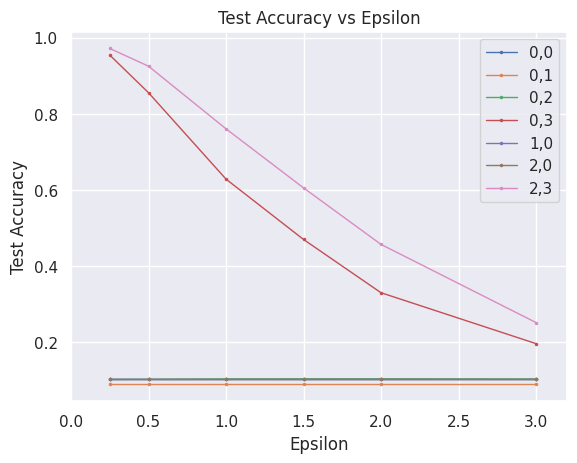

In [10]:
# graph results
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

for name, results in results_by_name.items():
    epsilons, test_accs = zip(*results)
    # plot with dots at each epsilon
    plt.plot(epsilons, test_accs, label=name, marker='o',
        linewidth=1, markersize=1.5)



# set x range to 0 to 3
plt.xlim(0, 3.2)

plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Epsilon")
plt.show()

